# Proyecto de Simulación

## David Sánchez Iglesias

### Librerías:

In [52]:
import numpy as np
from scipy import stats
from scipy.special import erfcinv
import matplotlib.pyplot as plt
import heapq
from numpy.random import default_rng

### Modelo de Seguros de Riesgo:

In [53]:
class InsuranceRiskModel:
                                                                                            #new_pol_fun,
    def __init__(self, new_pol_rate, lost_pol_rate, starting_capital, starting_policy_holders,        pol_time_fun, next_claim, claim_rate, limit_time, pol_pay):
        self.new_pol_rate = new_pol_rate
        self.lost_pol_rate = lost_pol_rate
        self.claim_rate = claim_rate
        
        # self.new_pol_function =new_pol_fun
        self.time_pol_in_firm_func = pol_time_fun
        self.claim_fun = next_claim
        
        #vars de referencia
        self.limit_time = limit_time
        self.pol_pay = pol_pay
        self.starting_capital = starting_capital
        self.initial_n_pols = starting_policy_holders
        self.current_pol_id = 1
        
        #estadisticas de varias simulaciones
        self.S_new_pols = []
        self.S_lost_pols = []
        self.S_claims = []
        self.S_capital = []
        self.S_capital_history = []
        self.S_time_steps = []
        
        self.rng = default_rng()
        
        self.initialize()
        
    def initialize(self):
        self.time = 0
        self.capital = self.starting_capital
        self.n_pols = self.initial_n_pols
        self.lost_pols = 0
        self.events_queue = []
        self.events = {'new_policyholder': self.new_policyholder,
                       'lost_policyholder': self.lose_policyholder,
                       'claim': self.next_claim}
        self.pol_list = []
        
        #Meter en la firma n_pols policyholders
        for i in range(self.n_pols):
            # Determino cuando dejaran de ser policyholders.
            t_e = self.time_pol_in_firm_func(self.lost_pol_rate)
            t_e = self.time + t_e
            # Y agrego los eventos para simularlos.
            if t_e < self.limit_time:
                heapq.heappush(self.events_queue, (t_e, 'lost_policyholder', i))
                self.pol_list.append(i)
                
        #Estadisticas
        self.new_pols = {} #{pol_id: time}
        self.pols_lost = {} #{pol_id: time}
        self.claims = {} #{time: amount}
        # self.capital_history = {self.time: self.capital}
        
        self.time_steps = [0]
        self.capital_history = [self.starting_capital]
        self.policyholder_count = [self.initial_n_pols]
        self.earnings = {}
        # self.claims_time = []
        # self.claims_amount = []
        # self.policy_lifecycles = [] 
        
    
    def next_new_policyholder(self):
        if self.time >= self.limit_time:
            return None
        t_e = self.rng.poisson(self.new_pol_rate)
        t_e = self.time + t_e
        if t_e < self.limit_time:
            heapq.heappush(self.events_queue, (t_e, 'new_policyholder'))
    
    def new_policyholder(self):
        pol_id = self.current_pol_id#para q no se repitan los ids, n_pols + lost_pols son la totalidad de pols q pasaron por la empresa hasta ahora.
        self.current_pol_id += 1
        self.n_pols += 1
        # Genero el tiempo de permanencia
        t_e = self.time_pol_in_firm_func(self.lost_pol_rate)
        t_e = self.time + t_e
        if t_e < self.limit_time:
            heapq.heappush(self.events_queue, (t_e, 'lost_policyholder', pol_id))
            self.pol_list.append(pol_id)
            self.new_pols[pol_id] = self.time
            self.next_new_policyholder()
    
    def lose_policyholder(self, pol_id):
        self.n_pols -= 1
        self.pol_list.remove(pol_id)
        self.lost_pols += 1
        self.pols_lost[pol_id] = self.time
        
    #Una reclamacion viene con una cantidad de dinero que distribuye F (asumo F por defecto como exponencial)
    def next_claim(self):
        t_e, money = self.claim_fun(self.claim_rate)
        t_e = self.time + t_e
        if t_e < self.limit_time:
            heapq.heappush(self.events_queue, (t_e, 'claim', money))
        
    def run(self):
        self.next_new_policyholder()
        self.next_claim()
        while self.time <= self.limit_time:
            if not self.events_queue:
                #Si la cola esta vacia es porq no ocurre ningun otro evento antes del tiempo limite.
                break
            event_tuple = heapq.heappop(self.events_queue)
            event_time = event_tuple[0]
            self.capital = self.capital + self.n_pols * self.pol_pay * (event_time - self.time)
            self.earnings[(self.time, event_time)] = self.n_pols * self.pol_pay
            self.time = event_time
            event_type = event_tuple[1]
            
            if event_type == 'new_policyholder':
                self.events[event_type]()
            elif event_type == 'lost_policyholder':
                self.events[event_type](event_tuple[2])
            elif event_type == 'claim':
                self.capital -= event_tuple[2]
                self.events[event_type]()
                self.claims[self.time] = event_tuple[2]
                # self.claims_time.append(self.time)
                # self.claims_amount.append(event_tuple[2])
                
            self.capital_history.append(self.capital)
            self.time_steps.append(self.time)
            self.policyholder_count.append(self.n_pols)
            
        
    def simulate(self, times):
        for _ in range(times):
            self.initialize()
            self.run()
            self.S_new_pols.append(self.new_pols)
            self.S_lost_pols.append(self.pols_lost)
            self.S_claims.append(self.claims)
            self.S_capital.append(self.capital)
            self.S_capital_history.append(self.capital_history)
            self.S_time_steps.append(self.time_steps)
            
    


In [54]:
# def new_client(rate):
#     return np.random.poisson(rate)

def policyholder_time_in_the_firm(rate):
    return np.random.exponential(1/rate)

def new_claim(rate, money_fun=None):
    """Devuelve el tiempo en el que se producira una reclamacion junto con el dinero que se reclamara."""
    if money_fun is None:
        return (np.random.poisson(rate), np.random.exponential(1))
    return (np.random.poisson(rate), money_fun())

## Iniciando el modelo:

In [55]:
model = InsuranceRiskModel(
    new_pol_rate=20,           # 15 nuevos clientes/mes
    lost_pol_rate=0.02,        # 8% de pérdida mensual
    starting_capital=1_000_000,
    starting_policy_holders=500,
    # new_pol_fun=lambda: np.random.poisson(15),
    pol_time_fun= policyholder_time_in_the_firm, #lambda rate: np.random.exponential(1/rate),
    next_claim= new_claim, #lambda rng: (rng.poisson(5), rng.pareto(2) * 500),  # 5 reclamos/mes, Pareto(α=2)
    claim_rate= 5,
    limit_time=120,             # 120 meses (10 años)
    pol_pay=150                 # $150 por póliza/mes
)

## Ejecutando el modelo

In [56]:
model.run()

## Algunos datos

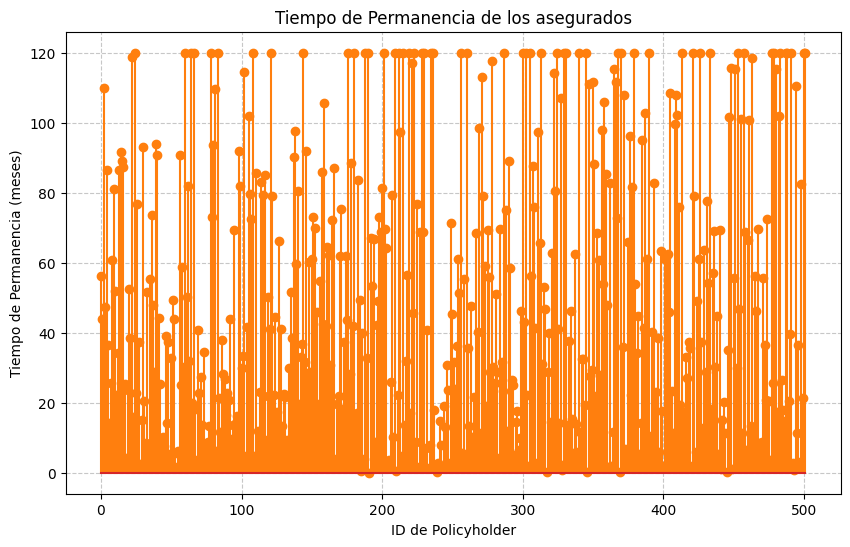

Tiempo maximo de permanencia de un policyholder:  120
Tiempo minimo de permanencia de un policyholder:  0.05633702962190119


In [57]:
# Cuanto tiempo ha permanecido cada policy holder con la firma?
total_times = {}
for pol_id in range(model.n_pols + model.lost_pols):
    if pol_id in model.new_pols.keys():
        start_time = model.new_pols[pol_id]
    else:
        start_time = 0
    if pol_id in model.pols_lost.keys():
        end_time = model.pols_lost[pol_id]
    else:
        end_time = model.limit_time
    total_times[pol_id] = end_time - start_time
    
plt.figure(figsize=(10, 6))
plt.stem(range(len(total_times.keys())), total_times.values(), 'C1-')
plt.xlabel('ID de Policyholder')
plt.ylabel('Tiempo de Permanencia (meses)')
plt.title('Tiempo de Permanencia de los asegurados')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

print('Tiempo maximo de permanencia de un policyholder: ', max(total_times.values()))
print('Tiempo minimo de permanencia de un policyholder: ', min(total_times.values()))
    

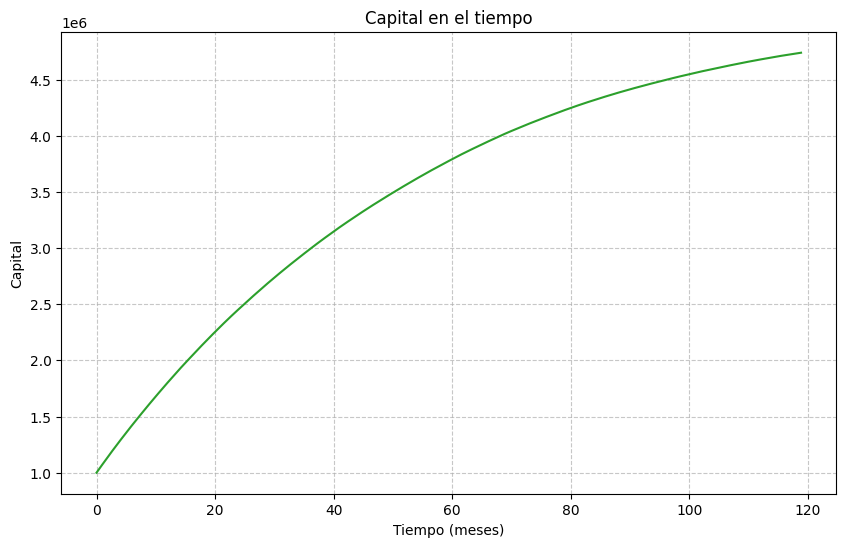

Capital total:  4738846.117558237


In [58]:
#Ganancias totales

plt.figure(figsize=(10, 6))
plt.plot(model.time_steps, model.capital_history, 'C2-')
plt.xlabel('Tiempo (meses)')
plt.ylabel('Capital')
plt.title('Capital en el tiempo')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

print('Capital total: ', model.capital)

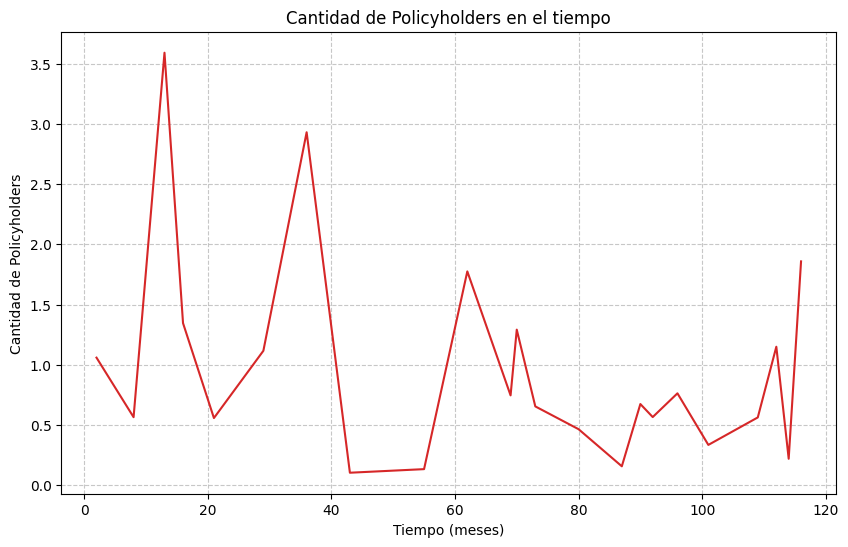

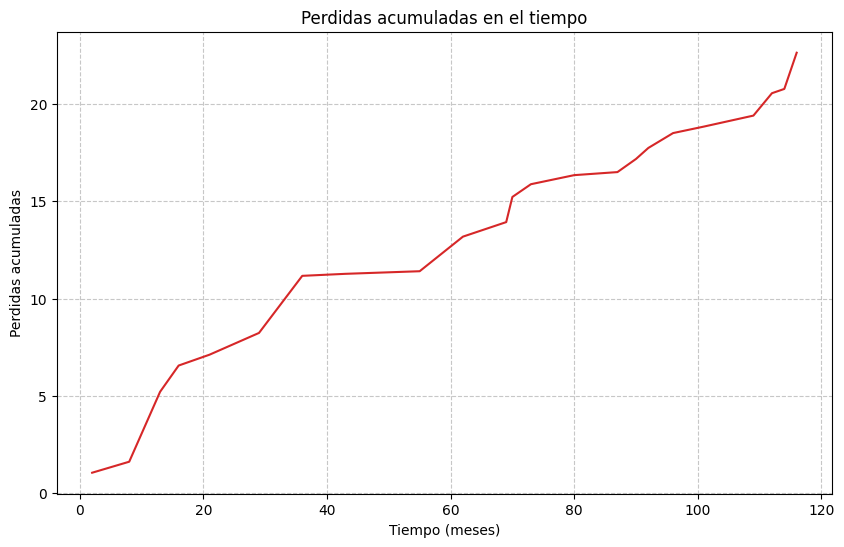

Perdidas totales:  450


In [59]:
#Perdidas totales

plt.figure(figsize=(10, 6))
plt.plot(model.claims.keys(), model.claims.values(), 'C3-')
plt.xlabel('Tiempo (meses)')
plt.ylabel('Cantidad de Policyholders')
plt.title('Cantidad de Policyholders en el tiempo')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

#Perdida acumulada
acumulacion = []
for claim in model.claims.keys():
    if acumulacion == []:
        acumulacion.append(model.claims[claim])
    else:
        acumulacion.append(acumulacion[-1] + model.claims[claim])


plt.figure(figsize=(10, 6))
plt.plot(model.claims.keys(), acumulacion, 'C3-')
plt.xlabel('Tiempo (meses)')
plt.ylabel('Perdidas acumuladas')
plt.title('Perdidas acumuladas en el tiempo')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()
print('Perdidas totales: ', model.lost_pols)

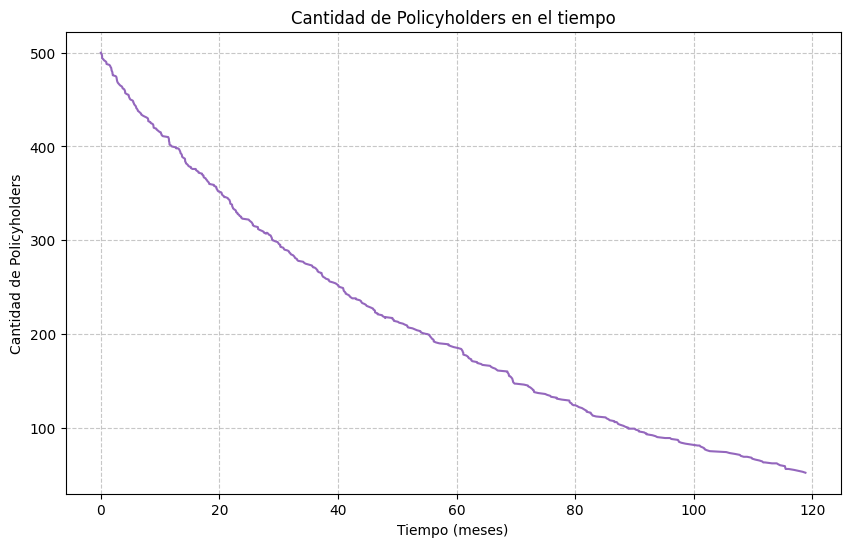

Media de asegurados:  271.98949579831935


In [60]:
#Media de asegurados
plt.figure(figsize=(10, 6))
plt.plot(model.time_steps, model.policyholder_count, 'C4-')
plt.xlabel('Tiempo (meses)')
plt.ylabel('Cantidad de Policyholders')
plt.title('Cantidad de Policyholders en el tiempo')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

print('Media de asegurados: ', np.mean(model.policyholder_count))

## Simulemos mas veces

In [61]:
model.simulate(1000)

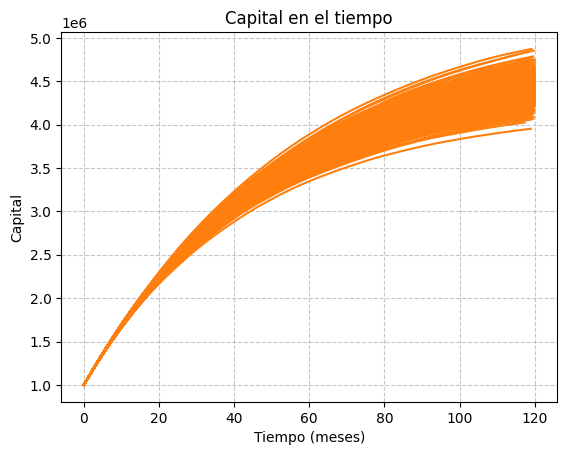

In [62]:
#Compara las capital_history de los 1000 simulaciones

for i in range(1000):
    plt.plot(model.S_time_steps[i], model.S_capital_history[i], 'C1-')
plt.xlabel('Tiempo (meses)')
plt.ylabel('Capital')
plt.title('Capital en el tiempo')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


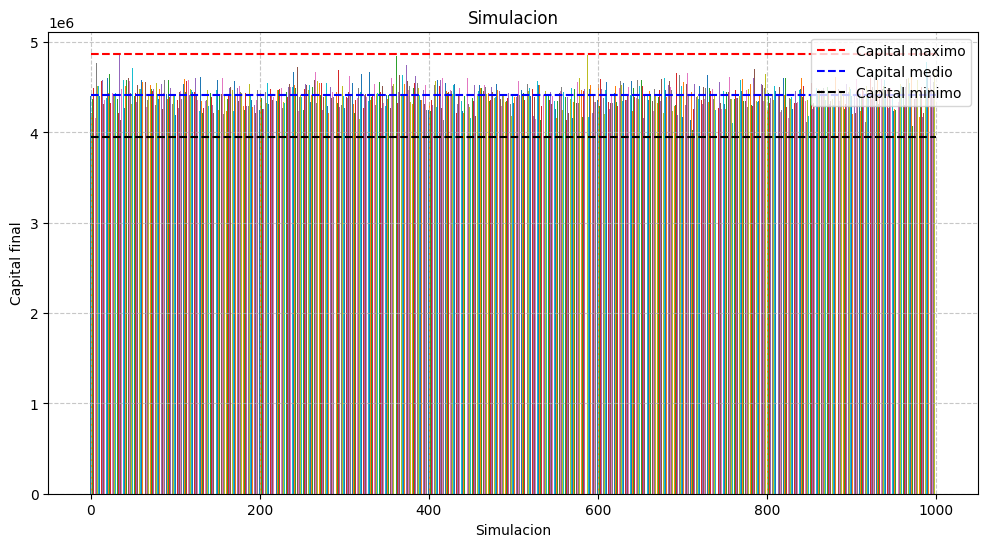

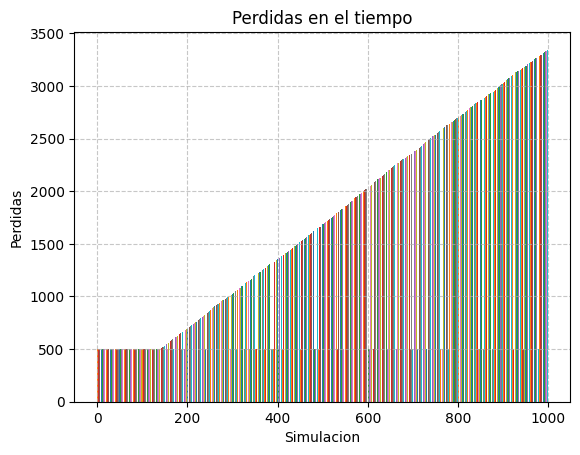

In [65]:
#Comparacion entre los capitales totales
plt.figure(figsize=(12, 6))
for i in range(1000):
    plt.bar(i, model.S_capital[i])
#Poner linea horizontal discontinua que llegue al eje y y se marque en la grafica para marcar el mayor valor
plt.hlines(max(model.S_capital), 0, 1000, colors='red', linestyles='dashed', label='Capital maximo')
plt.hlines(np.mean(model.S_capital), 0, 1000, colors='blue', linestyles='dashed', label='Capital medio')
plt.hlines(min(model.S_capital), 0, 1000, colors='black', linestyles='dashed', label='Capital minimo')
plt.legend()



plt.xlabel('Simulacion')
plt.ylabel('Capital final')
plt.title('Simulacion')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

#Comparacion entre las perdidas totales

for i in range(1000):
    plt.bar(i, model.S_lost_pols[i])

plt.xlabel('Simulacion')
plt.ylabel('Perdidas')
plt.title('Perdidas en el tiempo')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()